Script to test labelling functions for LA 4Ch data 

In [1]:
%matplotlib inline
import cv2 
import imageio
import pickle
import pydicom
import random
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
from skimage.segmentation import find_boundaries
from scipy.sparse import csr_matrix

import sys
sys.path.append('../metal')

In [2]:
def readData(path, to_print = False):
    """
    reads series of DICOM images given path to folder
    Params
    -------
    path: string
        - path to folder containing series of DICOM images
    to_print: bool
        - to print the series or not
    Return
    -------
    data: np.array, size: (50,168,208)
        - series of 50 DICOM images 
    """
    data = imageio.volread(path,'DICOM')
    
    if(to_print == True):
        for img in data:
            plt.imshow(img,cmap="gray")
            plt.pause(0.25)
    
    return data

In [3]:
def combineImg(data,masks):
    """
    Converts to RGB and overlays mask on data
    
    Params
    -------
    data: numpy array of shape (50,180,208)
    mask: numpy array of shape (50,180,208)
    
    Return
    -------
    new_data: numpy array of shape (50,180,208,3)
    
    """
    
    # data, mask shape - (50,208,210)
    frames,row,col = data.shape
    new_data = np.zeros((frames,row,col,3)) # shape (50,208,210)

    for iter in range(50):
        img = data[iter,:,:]
        msk = masks[iter,:,:]

        img1 = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        new_data[iter,:,:,:] = (img1 - np.min(img1))/(np.max(img1) - np.min(img1))

        # adding mask = 1 data points to blue channel
        new_data[iter,:,:,2] = new_data[iter,:,:,0] + 0.5*(msk==1)

        # adding mask = 2 data points to green channel
        new_data[iter,:,:,1] = new_data[iter,:,:,1] + 0.5*(msk==2)
    
    return new_data

In [4]:
def findOCIndex(masks, to_print = False):
    """
    Finds when the mitral valve opens and closes    
    
    Params
    -------
    mask: numpy array of shape (50,180,208)
    to_print: bool 0/1 
    
    Return
    -------
    index_open: int
    index_close: int
    
    """
    # 
    area_ra = np.sum(np.sum(masks==2.0,axis=2),axis=1) # area of right atrium
    area_la = np.sum(np.sum(masks==1.0,axis=2),axis=1) # area of left atrium

    # finding when mitral valve opens - when area is largest
    index_open = np.argmax(area_la)

    # finding when mitral valve closes - when area is smallest
    index_close = np.argmin(area_la)
    
    if(to_print):
        print('The mitral valve opens in frame no.',index_open)
        print('The mitral valve closes in frame no.',index_close) 
    
    return index_open, index_close

In [5]:
def OCIndex2Label(index_open, index_close):
    """
    Converts from open and close index to frame-wise labels   
    
    Params
    -------
    index_open: int
    index_close: int
    
    Return
    -------
    frame_labels: numpy array of shape (1,50)
    
    """
    index_open = int(index_open)
    index_close = int(index_close)
    
    frame_labels = np.zeros([1,50]);
    if(index_close >= index_open):
        frame_labels[0,index_open:index_close] = 1
    else:
        frame_labels[0,index_open:50] = 1
        frame_labels[0,0:index_close] = 1
        
    return frame_labels    

In [6]:
# load labels, data and masks
# change path to where data is
#path = '/Users/ashwiniramamoorthy/Desktop/Heart_MRI/data/'
path = '../data/'
with open(path+'all_labels.pickle', 'rb') as handle:
    labels = pickle.load(handle)

with open(path+'data.pickle', 'rb') as handle:
    data = pickle.load(handle)
    
with open(path+'mask.pickle', 'rb') as handle:
    mask = pickle.load(handle)

In [7]:
# function to compute metrics to evaluate labelling functions
from sklearn.metrics import recall_score, precision_score, f1_score

def evaluate_metrics(image_labels, predicted_labels):
    print('Precision:', precision_score(image_labels[predicted_labels != 0], predicted_labels[predicted_labels != 0]))
    print('Recall:', recall_score(image_labels[predicted_labels != 0], predicted_labels[predicted_labels != 0]))
    print("F1:", f1_score(image_labels[predicted_labels != 0], predicted_labels[predicted_labels != 0]))
    print('Accuracy: ', np.sum(predicted_labels == image_labels)/float(np.shape(np.where(predicted_labels != 0))[1]))
    print('Coverage: ', float(np.shape(np.where(predicted_labels != 0))[1])/float(len(image_labels)))

In [8]:
# converting labels from dict to matrix and using metrics
image_labels = np.zeros((len(labels.keys()),50))
predicted_labels = np.zeros((len(labels.keys()),50))

count = 0
for PID in labels.keys():
    start_frame, end_frame = labels[PID]
    image_labels[count,:] = OCIndex2Label(start_frame,end_frame)
    
    index_open, index_close = findOCIndex(mask[PID])
    predicted_labels[count,:] = OCIndex2Label(index_open, index_close) 
    count = count+1

evaluate_metrics(image_labels.flatten(), predicted_labels.flatten()) # is flatten necessary?

Precision: 0.9298469387755102
Recall: 1.0
F1: 0.9636483807005948
Accuracy:  1.725765306122449
Coverage:  0.5226666666666666


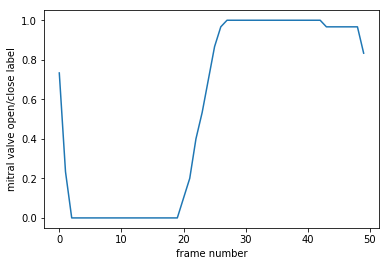

In [9]:
# plotting average of image labels across all subjects
avg_image_labels = np.mean(image_labels, axis = 0)

plt.figure()
plt.plot(np.arange(50),avg_image_labels)
plt.xlabel('frame number')
plt.ylabel('mitral valve open/close label')
plt.show()

#print(avg_image_labels)
# closes after frame 0, from frame 1
# opens after frame 19, in frame 20

1476888


Text(0, 0.5, 'slope of area')

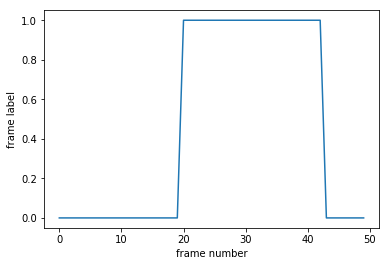

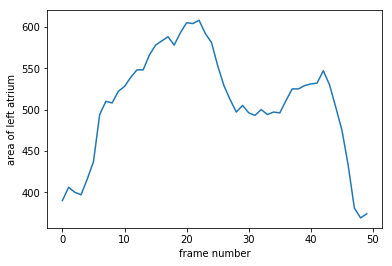

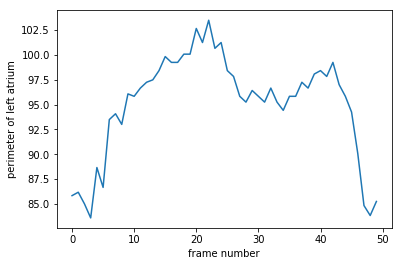

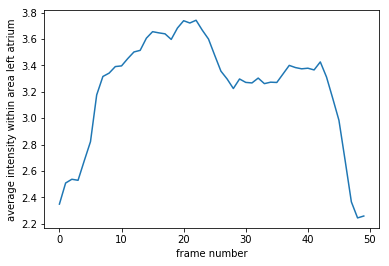

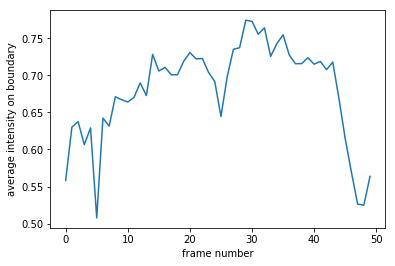

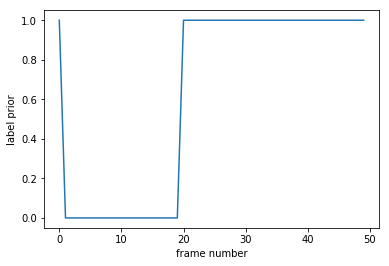

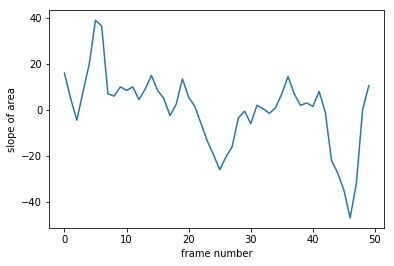

In [10]:
# plotting the label measure vs frame for a single example
eg_key = list(labels.keys())[0]
print(eg_key)

# printing image label of the eg
start_frame, end_frame = labels[eg_key]
plt.figure()
plt.plot(np.arange(50),np.transpose(OCIndex2Label(start_frame,end_frame)))
plt.xlabel('frame number')
plt.ylabel('frame label')


# computing area for each frame
area = np.sum(np.sum(mask[eg_key]==1.0,axis=2),axis=1)
plt.figure()
plt.plot(np.arange(50),area)
plt.xlabel('frame number')
plt.ylabel('area of left atrium')

# computing perimeter 
mask_la = mask[eg_key]
mask_la[mask_la!=1.0] = 0.0
mask_la = mask_la.astype(int)
perimeter = np.zeros((50,1))
for frame in range(50):
    regions = regionprops(mask_la[frame])
    perimeter[frame] = regions[0].perimeter
    
plt.figure()
plt.plot(np.arange(50),perimeter)
plt.xlabel('frame number')
plt.ylabel('perimeter of left atrium')


# computing area perimeter ratio 
#plt.figure()
#plt.plot(np.arange(50),np.divide(area,perimeter.squeeze()))
#plt.xlabel('frame number')
#plt.ylabel('ratio or area and perimeter of left atrium')

# computing average intensity within segment
avg_area_intensity = np.mean(np.mean(np.multiply(mask_la,data[eg_key]),axis=2),axis=1)
plt.figure()
plt.plot(np.arange(50),avg_area_intensity)
plt.xlabel('frame number')
plt.ylabel('average intensity within area left atrium')

# computing intensity over perimeter
boundary = find_boundaries(mask_la,mode='outer')
avg_intensity = np.mean(np.mean(np.multiply(boundary,data[eg_key]),axis=2),axis=1)
#print(avg_intensity.shape)
plt.figure()
plt.plot(np.arange(50),avg_intensity)
plt.xlabel('frame number')
plt.ylabel('average intensity on boundary')

# using frame number to define frame label 
label_prior = np.transpose(OCIndex2Label(20,1))
plt.figure()
plt.plot(np.arange(50),label_prior)
plt.xlabel('frame number')
plt.ylabel('label prior')

# using slope of area
area_diff = np.zeros((50,))
#area_diff[0] = area[0] - area[-1]
#area_diff[1:-1] = area[1:-1] - area[0:-2]
area_diff[0] = (area[1] - area[-1])/2.0
area_diff[-1] = (area[0] - area[-2])/2.0
area_diff[1:-2] = (area[2:-1] - area[0:-3])/2.0
plt.figure()
plt.plot(np.arange(50),area_diff)
plt.xlabel('frame number')
plt.ylabel('slope of area')


1476888


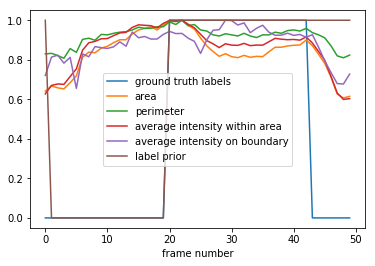

In [11]:
# plotting the normalized label measures vs frame for a single example
eg_key = list(labels.keys())[0]
print(eg_key)

#image label of the eg
start_frame, end_frame = labels[eg_key]
img_label = np.transpose(OCIndex2Label(start_frame,end_frame))

# area of mask
area = np.sum(np.sum(mask[eg_key]==1.0,axis=2),axis=1)

# computing perimeter 
mask_la = mask[eg_key]
mask_la[mask_la!=1.0] = 0.0
mask_la = mask_la.astype(int)
perimeter = np.zeros((50,1))
for frame in range(50):
    regions = regionprops(mask_la[frame])
    perimeter[frame] = regions[0].perimeter
    
# computing average intensity within segment
avg_area_intensity = np.mean(np.mean(np.multiply(mask_la,data[eg_key]),axis=2),axis=1)

# computing intensity over perimeter
boundary = find_boundaries(mask_la,mode='outer')
avg_intensity = np.mean(np.mean(np.multiply(boundary,data[eg_key]),axis=2),axis=1)

# using frame number to define frame label 
label_prior = np.transpose(OCIndex2Label(20,1))

plt.figure()
plt.plot(np.arange(50),img_label,label = 'ground truth labels')
plt.plot(np.arange(50),area/area.max(), label = 'area')
plt.plot(np.arange(50),perimeter/perimeter.max(), label = 'perimeter')
plt.plot(np.arange(50),avg_area_intensity/avg_area_intensity.max(), label = 'average intensity within area')
plt.plot(np.arange(50),avg_intensity/avg_intensity.max(), label = 'average intensity on boundary')
plt.plot(np.arange(50),label_prior, label = 'label prior')
plt.xlabel('frame number')
plt.legend()


In [12]:
#computing parameters for all subjects

area = np.zeros((len(labels),50))
perimeter = np.zeros((len(labels),50))
area_intensity = np.zeros((len(labels),50))
perimeter_intensity = np.zeros((len(labels),50))
label_prior = np.zeros((len(labels),50))

for iter in range(len(labels)):
    PID = list(labels.keys())[iter]
    print(PID)

    #image label of the eg
    #start_frame, end_frame = labels[eg_key]
    #img_label = np.transpose(OCIndex2Label(start_frame,end_frame))

    # area of mask
    area[iter,:] = np.squeeze(np.sum(np.sum(mask[PID]==1.0,axis=2),axis=1))

    # computing perimeter 
    mask_la = mask[PID]
    mask_la[mask_la!=1.0] = 0.0
    mask_la = mask_la.astype(int)
    #perimeter[iter,:] = np.zeros((50,1))
    for frame in range(50):
        regions = regionprops(mask_la[frame])
        perimeter[iter,frame] = regions[0].perimeter

    # computing average intensity within segment
    area_intensity[iter,:] = np.mean(np.mean(np.multiply(mask_la,data[PID]),axis=2),axis=1)

    # computing intensity over perimeter
    boundary = find_boundaries(mask_la,mode='outer')
    perimeter_intensity[iter,:] = np.mean(np.mean(np.multiply(boundary,data[PID]),axis=2),axis=1)

    # using frame number to define frame label 
    label_prior[iter,:] = np.squeeze(np.transpose(OCIndex2Label(20,1)))


1476888
1192908
1306467
1629308
2106029
2774599
3284626
1052327
2977350
2686576
3134226
5456802
4471596
5142661
5441523
5842628
2283643
5871626
3079449
3873369
4618076
5684778
1484554
3871554
3556300
3442724
4694866
1865913
5180537
4992065


Text(0, 0.5, 'label prior')

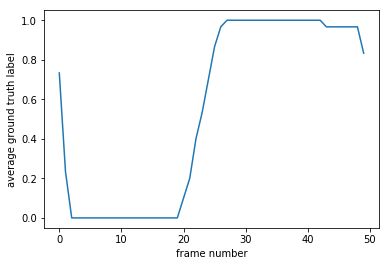

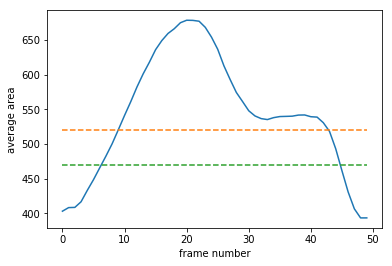

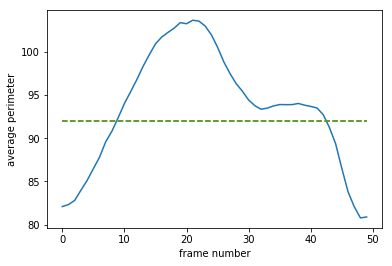

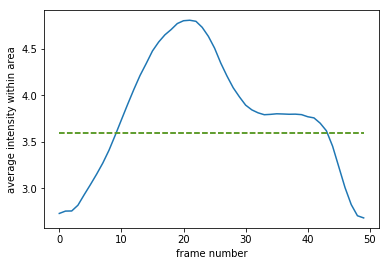

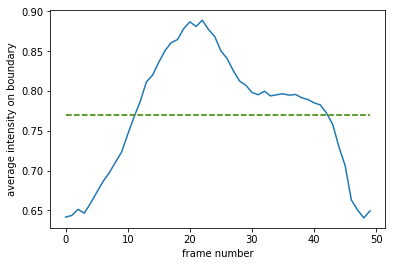

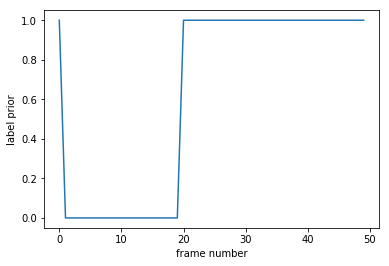

In [13]:
# plotting average of metrics across all subjects    
avg_area = np.mean(area,axis=0)
avg_perimeter = np.mean(perimeter,axis=0)
avg_area_intensity = np.mean(area_intensity,axis=0)
avg_perimeter_intensity = np.mean(perimeter_intensity,axis=0)

# selecting thresholds based on average images
area_thresh_high = 520
area_thresh_low = 470
perimeter_thresh_high = 92
perimeter_thresh_low = 92
area_intensity_thresh_high = 3.6
area_intensity_thresh_low = 3.6
perimeter_intensity_thresh_high = 0.77
perimeter_intensity_thresh_low = 0.77

plt.figure()
plt.plot(np.arange(50),np.mean(image_labels,axis=0),label = 'ground truth labels')
plt.xlabel('frame number')
plt.ylabel('average ground truth label')

plt.figure()
plt.plot(np.arange(50),avg_area, label = 'area')
plt.plot(np.arange(50),area_thresh_high*np.ones((50,)),'--',label = 'threshold')
plt.plot(np.arange(50),area_thresh_low*np.ones((50,)),'--',label = 'threshold')
plt.xlabel('frame number')
plt.ylabel('average area')

plt.figure()
plt.plot(np.arange(50),avg_perimeter, label = 'perimeter')
plt.plot(np.arange(50),perimeter_thresh_high*np.ones((50,)),'--',label = 'threshold')
plt.plot(np.arange(50),perimeter_thresh_low*np.ones((50,)),'--',label = 'threshold')
plt.xlabel('frame number')
plt.ylabel('average perimeter')

plt.figure()
plt.plot(np.arange(50),avg_area_intensity, label = 'average intensity within area')
plt.plot(np.arange(50),area_intensity_thresh_high*np.ones((50,)),'--',label = 'threshold')
plt.plot(np.arange(50),area_intensity_thresh_low*np.ones((50,)),'--',label = 'threshold')
plt.xlabel('frame number')
plt.ylabel('average intensity within area')

plt.figure()
plt.plot(np.arange(50),avg_perimeter_intensity, label = 'average intensity on boundary')
plt.plot(np.arange(50),perimeter_intensity_thresh_high*np.ones((50,)),'--',label = 'threshold')
plt.plot(np.arange(50),perimeter_intensity_thresh_low*np.ones((50,)),'--',label = 'threshold')
plt.xlabel('frame number')
plt.ylabel('average intensity on boundary')

plt.figure()
plt.plot(np.arange(50),label_prior[0,:], label = 'label prior')
plt.xlabel('frame number')
plt.ylabel('label prior')

In [14]:
# evaluating labelling functions using metal metrics
area_label = np.zeros(area.shape)
perimeter_label = np.zeros(area.shape)
area_intensity_label = np.zeros(area.shape)
perimeter_intensity_label = np.zeros(area.shape)

area_label[area >= area_thresh_high] = 2.0
area_label[area <= area_thresh_low] = 1.0
perimeter_label[perimeter >= perimeter_thresh_high] = 2.0
perimeter_label[perimeter <= perimeter_thresh_low] = 1.0
area_intensity_label[area_intensity >= area_intensity_thresh_high] = 2.0
area_intensity_label[area_intensity <= area_intensity_thresh_low] = 1.0
perimeter_intensity_label[perimeter_intensity >= perimeter_intensity_thresh_high] = 2.0
perimeter_intensity_label[perimeter_intensity <= perimeter_intensity_thresh_low] = 1.0

#print(image_labels[0,:])
#print(area_label[0,:])

L = np.stack((area_label,perimeter_label,area_intensity_label,perimeter_intensity_label,label_prior+1),axis=2) 
#(30,50,5)
Y = image_labels # (30,50)
L = np.reshape(L,(len(labels)*50,5)) # (1500,5)
Y = Y.flatten() #(1500,)

from metal.analysis import lf_summary
lf_summary(csr_matrix(L),csr_matrix(Y+1))


,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
0,"[1.0, 2.0]",0.846667,0.846667,0.521333,623,647,0.490551
1,"[1.0, 2.0]",1.000000,1.000000,0.641333,745,755,0.496667
2,"[1.0, 2.0]",1.000000,1.000000,0.641333,770,730,0.513333
3,"[1.0, 2.0]",1.000000,1.000000,0.641333,808,692,0.538667
4,"[1.0, 2.0]",1.000000,1.000000,0.641333,1377,123,0.918000


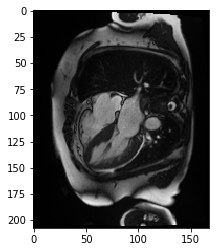

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


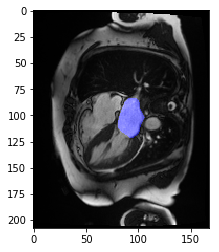

In [15]:
# printing out example key
labels.keys()

plt.figure(1)
PID = '1306467'
out = data[PID]
plt.imshow(out[40,:,:],cmap='gray')
plt.show()

combined = combineImg(data[PID],mask[PID])
plt.figure(2)
plt.imshow(combined[40,:,:],cmap='gray')
plt.show()

In [16]:
# load data corresponding to labels
data = {}

for PID in labels.keys():
    temp_data = readData(path+'LAX_4ch_sample/'+PID)
    data[PID] = temp_data.transpose([0,2,1]) # shape (50,208,180)

path = '/Users/ashwiniramamoorthy/Desktop/Heart_MRI/data/'
with open(path+'data.pickle', 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

FileNotFoundError: No such file: '/Users/ashwiniramamoorthy/Desktop/Heart_MRI/heart_mri/data/LAX_4ch_sample/1476888'

In [ ]:
# load segmentation masks corresponding to labels
mask = {}

for PID in labels.keys():
    temp_mask = np.load(path+'LAX_4ch_sample_segmented/'+PID+'/segmentation.npy')
    temp_mask = temp_mask.transpose([3,0,1,2])
    mask[PID] = temp_mask.squeeze(3) # shape (50,208,180)

path = '/Users/ashwiniramamoorthy/Desktop/Heart_MRI/data/'
with open(path+'mask.pickle', 'wb') as handle:
    pickle.dump(mask, handle, protocol=pickle.HIGHEST_PROTOCOL)